## Preamble

+ Run these lines of code first to import the necessary libraries and set up the plotting environment.

In [1]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


# plt.style.use("dark_background")

## How do inner products scale with system dimensionality?

+ As our test system, we consider the Lorenz-96 system. Given a vector $\mathbf{x} \in \mathbb{R}^{D}$, the dynamics are given by

$$
\dot{x}_i = (x_{i+1} - x_{i-2}) x_{i-1} - x_i + F
$$

where $F$ is a constant forcing term that controls the bifurcation to chaos. We assume that the variables are coupled together on a ring, and consider the case where $F = 8$. We will vary $D$ in order to examine the effect of dimensionality on the dynamics.

(-8.64900549214583, 13.080709536934034, -9.547737346574515, 15.287917008868487)

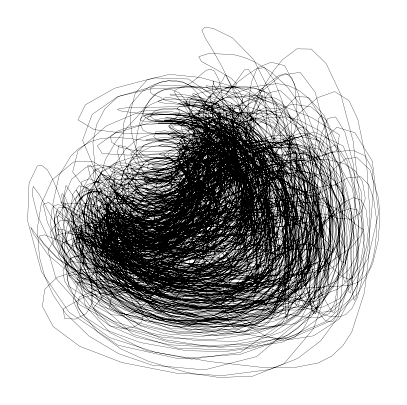

In [2]:
from scipy.integrate import solve_ivp


class Lorenz96:
    """
    Lorenz 96 model with constant forcing
    """

    def __init__(self, n=4, f=8.0):
        self.f = f
        self.n = n

    def rhs(self, t, X):

        Xdot = np.zeros_like(X)
        Xdot[2:-1] = (X[3:] - X[:-3]) * X[1:-2] - X[2:-1] + self.f
        Xdot[0] = (X[1] - X[-2]) * X[-1] - X[0] + self.f
        Xdot[1] = (X[2] - X[-1]) * X[0] - X[1] + self.f
        Xdot[-1] = (X[0] - X[-3]) * X[-2] - X[-1] + self.f

        return Xdot
    
    def __call__(self, *args, **kwargs):
        return self.rhs(*args, **kwargs)

eq = Lorenz96



nval = 15

eq = Lorenz96(n=nval)
ic = eq.f * np.ones(eq.n) #+ 0.01 * np.random.normal(size=eq.n)
ic[0] += 0.01
# sol = solve_ivp(eq.rhs, [0, 30], ic, vectorized=True, max_step=0.01)
sol = solve_ivp(eq, (0, 500), ic, method="Radau")
ysol = sol.y.T
ysol = ysol[500:] # discard transient

plt.figure(figsize=(5, 5))
plt.plot(ysol[:, 0], ysol[:, 1], 'k', linewidth=0.2);
plt.axis("off")



+ We define a "spherized" two-point correlation function. Given two system states $\mathbf{x}(t), \mathbf{x}(t + \tau) \in \mathbb{R}^{D}$, we define the spherized inner product as

$$
g_2(\tau) = \langle \mathbf{x}(t), \mathbf{x}(t + \tau) \rangle_t = \frac{\mathbf{x}(t_1) \cdot \mathbf{x}(t_2)}{\|\mathbf{x}(t_1)\| \|\mathbf{x}(t_2)\|}
$$

This expression corresponds to the inner product between the unit vectors associated with the system states at times $t$ and $t + \tau$. 

Text(0, 0.5, 'Correlation')

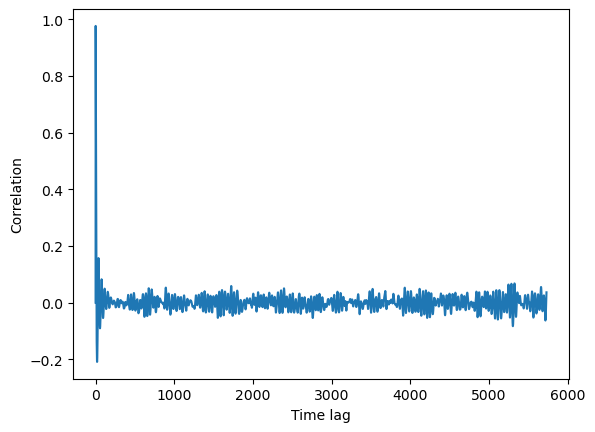

In [4]:
def twopoint_correlation(X, center=True, spherize=True):
    """
    Compute the instantaneous pairwise correlation between all pairs of timepoints

    Args:
        X (np.ndarray): shape (T, D)
        center (bool): If True, subtract the mean from each timepoint
        spherize (bool): If True, normalize each timepoint to a unit length vector
    """
    if center:
        X -= np.mean(X, axis=1, keepdims=True)
    if spherize:
        X /= np.linalg.norm(X, axis=1, keepdims=True)
    max_time = X.shape[0] // 2
    corrs = np.zeros(max_time)
    for i in range(1, max_time):
        corrs[i] = np.mean(np.sum(X[i:] * X[:-i], axis=1))
    return corrs

g2 = twopoint_correlation(ysol)
plt.figure()
plt.plot(g2)
plt.xlabel("Time lag")
plt.ylabel("Correlation")

## How do the asymptotic correlations depend on dimensionality?

+ We loop over many values of $N$, simulate the system, and then record the two-point correlation function for each value of $N$.

+ As a point of comparison, we also record the two-point correlation function for randomly-sampled unit vectors of equal dimension.
+ + There is a small subtlety here: Uniform sampling of unit vectors in high dimensions is not straightforward.

In [6]:


nvals = np.arange(5, 300, 5)
# nvals = np.unique(5 * np.logspace(0, 3, 30)).astype(int)
all_corrs = []
all_corrs_gaussian = []
for nval in nvals:
    print(f"Starting nval = {nval}")
    eq = Lorenz96(n=nval)
    ic = eq.f * np.ones(eq.n) #+ 0.01 * np.random.normal(size=eq.n)
    ic[0] += 0.01
    sol = solve_ivp(eq, (0, 500), ic, method="Radau")
    ysol = sol.y.T
    ysol = ysol[500:] # discard transient

    all_corrs.append(twopoint_correlation(ysol))

    ## create equal-sized random Gaussian steps
    ysol_normal = np.random.normal(size=ysol.shape)
    all_corrs_gaussian.append(twopoint_correlation(ysol_normal))





Starting nval = 5
Starting nval = 10
Starting nval = 15


## We fit a power law in the large-$N$ limit

+ We consider only the asymptotic behavior of the correlation function (large-$\tau$), and fit a power law to the standard deviation of this asymptote in the large-$N$ limit.

[ 0.06399139 -0.51723679]


Text(0, 0.5, 'Asymptotic Standard deviation of pairwise correlations')

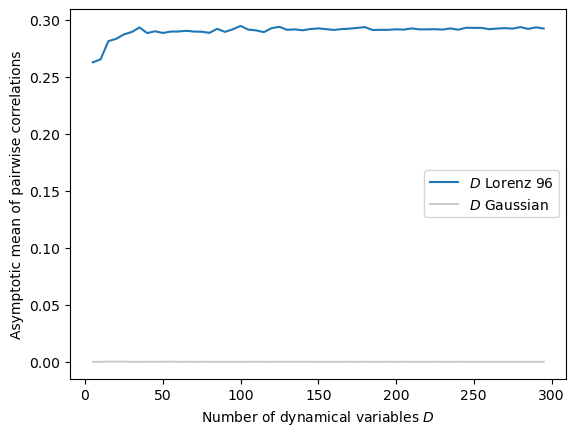

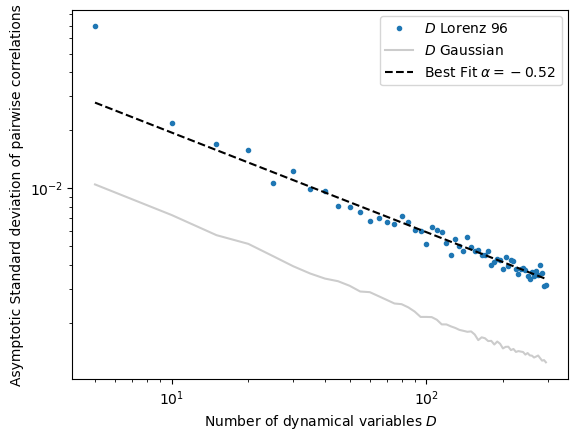

In [204]:



mean_asymp = [np.mean(corr[-3000:]) for corr in all_corrs]
std_asymp = [np.std(corr[-3000:]) for corr in all_corrs]

mean_asymp_gaussian = [np.mean(corr[-3000:]) for corr in all_corrs_gaussian]
std_asymp_gaussian = [np.std(corr[-3000:]) for corr in all_corrs_gaussian]

plt.figure()
plt.plot(nvals, mean_asymp, label="$D$ Lorenz 96")
plt.plot(nvals, mean_asymp_gaussian, color=(0.0, 0.0, 0.0, 0.2), label="$D$ Gaussian")
plt.xlabel("Number of dynamical variables $D$")
plt.ylabel("Asymptotic mean of pairwise correlations")
plt.legend()

plt.figure()
plt.loglog(nvals, std_asymp, '.', label="$D$ Lorenz 96")
plt.loglog(nvals, std_asymp_gaussian,  color=(0.0, 0.0, 0.0, 0.2), label="$D$ Gaussian")


# Fit custom power law
from scipy.optimize import curve_fit
power_law = lambda x, a, b:  a * x**b
popt, pcov = curve_fit(power_law, nvals[-20:], std_asymp[-20:])
print(popt)
plt.plot(nvals, power_law(nvals, *popt), '--k', label=f"Best Fit $\\alpha = {popt[1]:.2f}$")

# invsq_law = lambda x, a:  a * x**(-0.5)
# popt, pcov = curve_fit(invsq_law, nvals[-20:], std_asymp[-20:])
# plt.plot(nvals, invsq_law(nvals, *popt), '--r', label=f"$\\alpha = -1/2$")
# print(f"Equivalent Normal is {1/np.sqrt(popt[0])} times the number of dynamical variables $D$")

## Inverse linear law as check
# invlin_law = lambda x, a:  a * x**(-1.0)
# popt, pcov = curve_fit(invlin_law, nvals[-20:], std_asymp[-20:])
# plt.plot(nvals, invlin_law(nvals, *popt), '--b', label=f"$\\alpha = -1$")

plt.legend()
plt.xlabel("Number of dynamical variables $D$")
plt.ylabel("Asymptotic Standard deviation of pairwise correlations")




### A mystery: why do we have a prefactor?

+ For unit vectors uniformly sampled from the surface of a unit hypersphere, the asymptotic correlation function should exhibit fluctuations around zero exactly equal to $1/\sqrt{N}$.

+ However, the asymptotic correlation function for the Lorenz-96 system exhibits fluctuations around zero that go as $\alpha/\sqrt{N}$, where the prefactor $\alpha$ is a constant.

+ Generating random Gaussian vectors in high dimensions, and then normalizing them to unit vectors, yields the same prefactor. From this we infer that this "null model" is not equivalent to uniform sampling from the surface of a unit hypersphere.



### Other notions of dimensionality to try:

+ [Grassberger-Procaccia correlation dimension:](http://www.scholarpedia.org/article/Grassberger-Procaccia_algorithm) very similar, but small-$\epsilon$ scaling limit of nearest neighbor count
+ + Probably should use Clauset et al. power law estimator for this

+ [PCA dimension](https://www.biorxiv.org/content/10.1101/2020.12.19.423618v3.full.pdf): participation ratio of eigenvalue spectrum

#### Useful links:

[Stackexchange](https://stats.stackexchange.com/questions/85916/distribution-of-scalar-products-of-two-random-unit-vectors-in-d-dimensions) summarizing [Baravinok's notes](https://dept.math.lsa.umich.edu/~barvinok/total710.pdf)
